In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from os import listdir

from numpy import zeros
from numpy import asarray
from numpy import savez_compressed

from keras import callbacks
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Activation, Flatten 
from keras.layers import  Dropout, Conv2D, BatchNormalization 
from keras.layers import  MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import callbacks

In [2]:
repTrain  = 'train_images/'
repTest   = 'test_images/'

In [3]:
train = pd.read_csv('train.csv')
sep = '_'
train['image'] = train['Image_Label'].apply(lambda x: x.split(sep)[0])
train['label'] = train['Image_Label'].apply(lambda x: x.split(sep)[1])
train = train.drop(['Image_Label'], axis=1)
train = train.dropna()
train.head()

,EncodedPixels,image,label
0,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
4,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish
5,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower
7,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar


In [4]:
#On effectue une dichotomisation des classes de nuages
classes = ['Fish', 'Flower', 'Gravel', 'Sugar']
train_encoded = train
train_encoded= train_encoded.join(pd.get_dummies(train_encoded['label']))

#On supprime ensuite les colonnes "encoded Pixels" et "label", inutiles pour l'aggregation qui suit
train_encoded = train_encoded.drop(['EncodedPixels', 'label'], axis=1)

#Enfin on fait un sous-total pour ne conserver qu'une ligne par image
train_encoded = train_encoded.groupby(['image']).sum()

train_encoded = train_encoded.reset_index(level=0)
train_encoded.head()

,image,Fish,Flower,Gravel,Sugar
0,0011165.jpg,1,1,0,0
1,002be4f.jpg,1,1,0,1
2,0031ae9.jpg,1,1,0,1
3,0035239.jpg,0,1,1,0
4,003994e.jpg,1,0,1,1


In [5]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
image_width = 140
image_height = 210

datagen = ImageDataGenerator(rescale=1./255, 
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             fill_mode='constant',
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=.1,                             
                             validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_encoded,
    directory=repTrain,
    x_col='image',
    y_col=classes,
    subset='training',
    class_mode='raw',
    shuffle=True,                    #On melange tout
    target_size=(image_width, image_height),          #On divise la taille par 10
    batch_size=batch_size)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_encoded,
    directory=repTrain,
    x_col='image',
    y_col=classes,
    subset='validation',
    class_mode='raw',
    shuffle=True,
    target_size=(image_width, image_height),
    batch_size=batch_size)

Found 4437 validated image filenames.
Found 1109 validated image filenames.


In [6]:
def creation_model(affichage = False):
    
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5),
                     padding='valid',
                     input_shape=(image_width, image_height,3),
                     activation = 'elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3),
                     padding='valid',
                     activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(16, (3,3), padding='valid',activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation = 'elu'))
    
    model.add(Dense(4, activation='sigmoid'))
    
    if affichage == True:
        model.summary()
        
    return model

In [7]:
def affiche_resultat(history, epoch, lr):
    
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14,5))
    plt.suptitle(f"Résultats obtenus avec un learning rate de {lr}")
    
    epoques = np.arange(1, epoch+1, 1)
    # Labels des axes
    plt.subplot(121)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Courbe de la précision sur l'échantillon d'entrainement
    plt.plot(epoques,
             train_accuracy,
             label = 'Training Accuracy',
             color = 'blue')

    # Courbe de la précision sur l'échantillon de validation
    plt.plot(epoques,
             val_accuracy,
             label = 'Validation Accuracy',
             color = 'red')

    # Affichage de la légende
    plt.legend()

    plt.subplot(122)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Courbe de la précision sur l'échantillon d'entrainement
    plt.plot(epoques,
             train_loss,
             label = 'Training loss',
             color = 'blue')

    # Courbe de la précision sur l'échantillon de validation
    plt.plot(epoques,
             val_loss,
             label = 'Validation loss',
             color = 'red')

    # Affichage de la légende
    plt.legend()
    
    # Affichage de la figure
    plt.show()

In [8]:
e_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                     patience = 3,
                                     mode = 'min',
                                     restore_best_weights = True)

In [9]:
EPOCHS = 10
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

In [10]:
model = creation_model(True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 136, 206, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 68, 103, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 66, 101, 32)       18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 48, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 24, 16)        0

In [11]:
lr = 1e-4
model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[e_stopping])

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
138/138 [==============================] - 186s 1s/step - loss: 0.6846 - accuracy: 0.0919 - val_loss: 0.6700 - val_accuracy: 0.0919
Epoch 2/10
138/138 [==============================] - 184s 1s/step - loss: 0.6704 - accuracy: 0.0801 - val_loss: 0.6596 - val_accuracy: 0.0864
Epoch 3/10
138/138 [==============================] - 184s 1s/step - loss: 0.6504 - accuracy: 0.1263 - val_loss: 0.6631 - val_accuracy: 0.0983
Epoch 4/10
138/138 [==============================] - 184s 1s/step - loss: 0.6411 - accuracy: 0.1651 - val_loss: 0.6448 - val_accuracy: 0.1048
Epoch 5/10
138/138 [==============================] - 184s 1s/step - loss: 0.6248 - accuracy: 0.1850 - val_loss: 0.6173 - val_accuracy: 0.2399
Epoch 6/10
138/138 [==============================] - 184s 1s/step - loss: 0.6145 - accuracy: 0.2108 - val_loss: 0.6402 - val_accuracy: 0.2142
Epoch 7/10
138/138 [==============================] - 184s 1s/step - loss: 0.6220 - accuracy: 0.2425 - val_loss: 0.7945 - val_accuracy: 0.1278

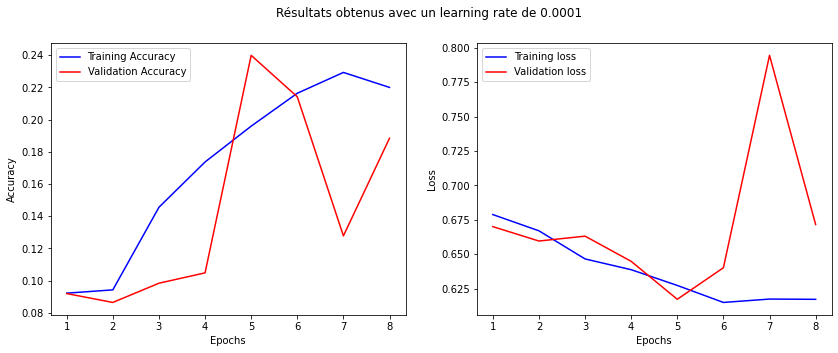

In [13]:
epoch_real = len(history.history['loss'])
affiche_resultat(history, epoch_real, lr)

In [14]:
model = creation_model()

In [15]:
lr = 1e-5
model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[e_stopping])

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
138/138 [==============================] - 185s 1s/step - loss: 0.6868 - accuracy: 0.0977 - val_loss: 0.6747 - val_accuracy: 0.0772
Epoch 2/10
138/138 [==============================] - 183s 1s/step - loss: 0.6801 - accuracy: 0.0772 - val_loss: 0.6736 - val_accuracy: 0.0781
Epoch 3/10
138/138 [==============================] - 183s 1s/step - loss: 0.6783 - accuracy: 0.0763 - val_loss: 0.6758 - val_accuracy: 0.0781
Epoch 4/10
138/138 [==============================] - 183s 1s/step - loss: 0.6758 - accuracy: 0.0723 - val_loss: 0.6744 - val_accuracy: 0.0754
Epoch 5/10
138/138 [==============================] - 183s 1s/step - loss: 0.6738 - accuracy: 0.0807 - val_loss: 0.6712 - val_accuracy: 0.0772
Epoch 6/10
138/138 [==============================] - 183s 1s/step - loss: 0.6745 - accuracy: 0.0717 - val_loss: 0.6698 - val_accuracy: 0.0781
Epoch 7/10
138/138 [==============================] - 183s 1s/step - loss: 0.6686 - accuracy: 0.0809 - val_loss: 0.6720 - val_accuracy: 0.0781

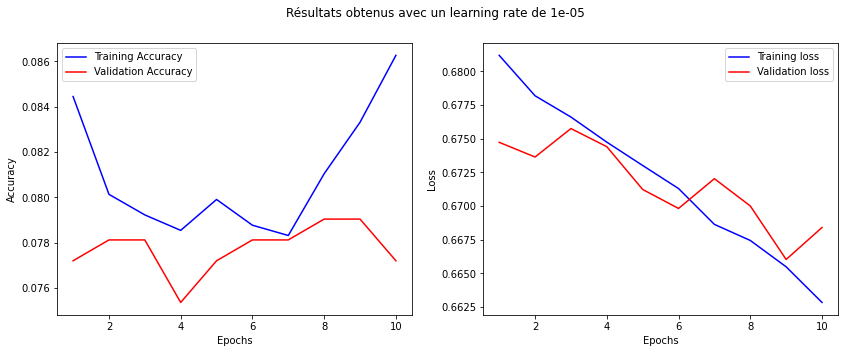

In [17]:
epoch_real = len(history.history['loss'])
affiche_resultat(history, epoch_real, lr)

In [18]:
model = creation_model()

In [19]:
lr = 1e-6
model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[e_stopping])

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
138/138 [==============================] - 184s 1s/step - loss: 0.6865 - accuracy: 0.1575 - val_loss: 0.6797 - val_accuracy: 0.0818
Epoch 2/10
138/138 [==============================] - 183s 1s/step - loss: 0.6824 - accuracy: 0.0835 - val_loss: 0.6788 - val_accuracy: 0.0790
Epoch 3/10
138/138 [==============================] - 183s 1s/step - loss: 0.6810 - accuracy: 0.0780 - val_loss: 0.6793 - val_accuracy: 0.0781
Epoch 4/10
138/138 [==============================] - 183s 1s/step - loss: 0.6787 - accuracy: 0.0788 - val_loss: 0.6786 - val_accuracy: 0.0790
Epoch 5/10
138/138 [==============================] - 183s 1s/step - loss: 0.6805 - accuracy: 0.0741 - val_loss: 0.6782 - val_accuracy: 0.0772
Epoch 6/10
138/138 [==============================] - 183s 1s/step - loss: 0.6783 - accuracy: 0.0772 - val_loss: 0.6770 - val_accuracy: 0.0800
Epoch 7/10
138/138 [==============================] - 183s 1s/step - loss: 0.6792 - accuracy: 0.0798 - val_loss: 0.6751 - val_accuracy: 0.0763

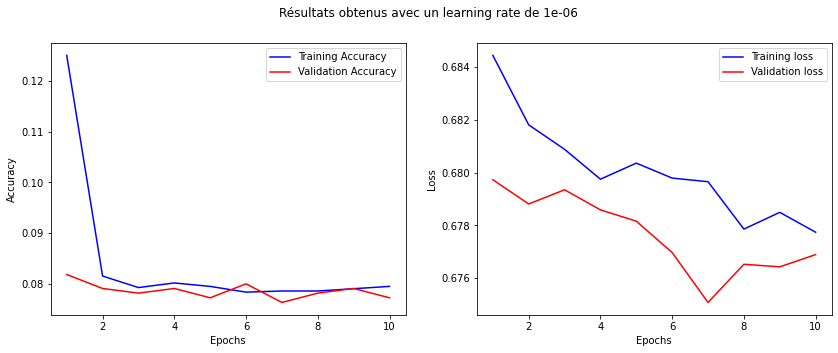

In [21]:
epoch_real = len(history.history['loss'])
affiche_resultat(history, epoch_real, lr)

In [22]:
model = creation_model()

In [23]:
lr = 1e-3
model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[e_stopping])

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
138/138 [==============================] - 187s 1s/step - loss: 0.7126 - accuracy: 0.1907 - val_loss: 0.6752 - val_accuracy: 0.2132
Epoch 2/10
138/138 [==============================] - 188s 1s/step - loss: 0.6692 - accuracy: 0.1702 - val_loss: 0.6600 - val_accuracy: 0.0910
Epoch 3/10
138/138 [==============================] - 184s 1s/step - loss: 0.6591 - accuracy: 0.1633 - val_loss: 0.7482 - val_accuracy: 0.0809
Epoch 4/10
138/138 [==============================] - 184s 1s/step - loss: 0.6570 - accuracy: 0.1803 - val_loss: 0.6256 - val_accuracy: 0.1314
Epoch 5/10
138/138 [==============================] - 184s 1s/step - loss: 0.6484 - accuracy: 0.1729 - val_loss: 0.6655 - val_accuracy: 0.1259
Epoch 6/10
138/138 [==============================] - 183s 1s/step - loss: 0.6282 - accuracy: 0.2211 - val_loss: 0.6404 - val_accuracy: 0.1379
Epoch 7/10
138/138 [==============================] - 184s 1s/step - loss: 0.6323 - accuracy: 0.2013 - val_loss: 0.6158 - val_accuracy: 0.1618

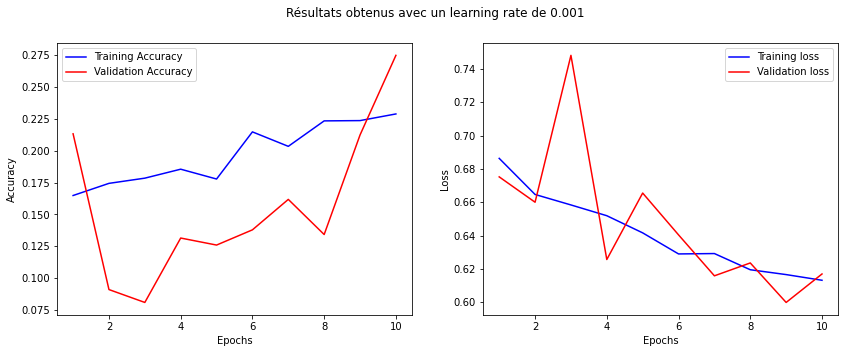

In [25]:
epoch_real = len(history.history['loss'])
affiche_resultat(history, epoch_real, lr)